In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
from collections import Counter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from urllib import request
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from ppxf.ppxf_util import log_rebin
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
import csv
from scipy import ndimage
import glob
from time import time 
from astropy.wcs import WCS

In [3]:
output_voronoi='/home/sabrinadopico/Área de trabalho/análise3866/2-Voronoi/'
output_espectrosr='/home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec/'
output_ppxfr='/home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/out/'
base_dir='/home/sabrinadopico/Área de trabalho/análise3866/basesGM/'

/tmp/ipykernel_12258/2781265003.py:42: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(bin_variance) if bin_variance is not None else np.zeros_like(bin_flux)


Espectro e variância para o bin 0 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin0.txt
Espectro e variância para o bin 1 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin1.txt
Espectro e variância para o bin 2 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin2.txt
Espectro e variância para o bin 3 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin3.txt
Espectro e variância para o bin 4 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin4.txt
Espectro e variância para o bin 5 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin5.txt
Espectro e variância para o bin 6 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_bin6.txt
Espectro e variância para o bin 7 salvos em /home/sabrinadopico/Área de trabalho/análise3866/4-PpxfR/espec//espectro_b

/tmp/ipykernel_12258/2781265003.py:386: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()


Emission lines included in gas templates:
['Halpha' '[NII]6583d']
 Best Fit:       Vel     sigma
 comp.  0:        20       263
 comp.  1:         2        25
Attenuation Parameters 0: 0.000
chi2/DOF: 0.01173; DOF: 154; degree = 4; mdegree = 4
method = capfit; Jac calls: 12; Func calls: 134; Status: 3
linear_method = lsq_box; Nonzero Templates (>0.1%): 22/114
Desired Delta Chi^2: 0
Current Delta Chi^2: -0
Elapsed time in PPXF: 4.14 s
++++++++++++++++++++++++++++++
Gas V= 1.976 and sigma= 25 km/s
Emission lines peak intensity:
      Halpha: 1.36
  [NII]6583d: 0.00697
------------------------------
(28, 4)
112
[[1.23670530e-01 8.23532880e-02 4.09671386e-02 0.00000000e+00]
 [1.03788546e-01 6.92483482e-02 3.45082062e-02 0.00000000e+00]
 [8.40605180e-02 5.62917995e-02 2.81000360e-02 0.00000000e+00]
 [6.48535283e-02 4.38134694e-02 2.19709088e-02 0.00000000e+00]
 [4.66824218e-02 3.21222195e-02 1.63038615e-02 8.42342034e-05]
 [3.04737573e-02 2.16022026e-02 1.11454022e-02 1.20652078e-04]
 [1.73

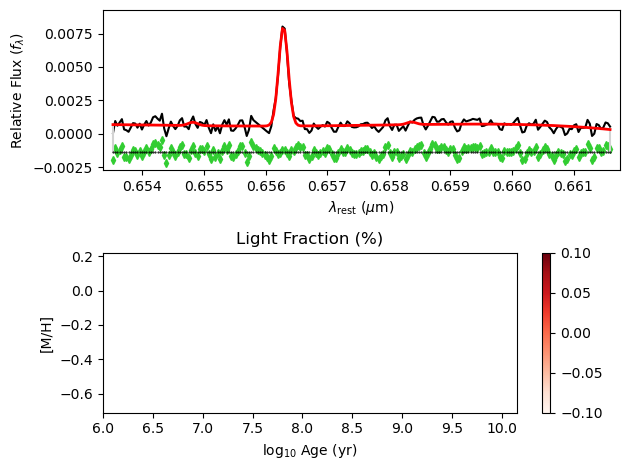

In [5]:
# Carrega os dados
with fits.open(output_voronoi+'voronoiR.fits') as hdul:
    data = hdul[0].data
    header = hdul[0].header
    variance_data = hdul[1].data if len(hdul) > 1 else None

# Carrega o arquivo de binagem
binning_data = np.loadtxt(output_voronoi+'voronoi_n2.txt', skiprows=1)
X = binning_data[:, 0].astype(int)
Y = binning_data[:, 1].astype(int)
binNum = binning_data[:, 2].astype(int)
num_bins = np.max(binNum) + 1

# Obtenha o array de comprimentos de onda
wavelength_start = header['CRVAL3']
wavelength_delta = header['CDELT3']
num_wavelengths = data.shape[0]
wavelengths = wavelength_start + np.arange(num_wavelengths) * wavelength_delta
# Loop para processar todos os bins
for bin_num in range(num_bins):
    mask = binNum == bin_num
    x_coords = X[mask]
    y_coords = Y[mask]

    if len(x_coords) == 0:
        continue

    # Inicializa os espectros e variâncias
    bin_flux = np.zeros(data.shape[0])
    bin_variance = np.zeros(variance_data.shape[0]) if variance_data is not None else None
    
    for x, y in zip(x_coords, y_coords):
        bin_flux += data[:, y, x]
        if variance_data is not None:
            bin_variance += variance_data[:, y, x]

    # Média dos fluxos e variâncias
    bin_flux /= len(x_coords)
    if bin_variance is not None:
        bin_variance /= len(x_coords)

    noise = np.sqrt(bin_variance) if bin_variance is not None else np.zeros_like(bin_flux)

    # Substituir NaNs pela mediana dos valores de noise
    if np.any(np.isnan(noise)):
        median_noise = np.nanmedian(noise)
        noise[np.isnan(noise)] = median_noise
    # Aqui você implementa a lógica para definir um valor mínimo de ruído
    if variance_data is not None:
        positive_variance = variance_data[variance_data > 0]
        if positive_variance.size > 0:
            min_noise_value = np.median(np.sqrt(positive_variance)) * 0.1  # Por exemplo, 10% da mediana
            noise[noise < min_noise_value] = min_noise_value
    # Salva o espectro e a variância em um arquivo .txt
    output_file_path = f'{output_espectrosr}/espectro_bin{bin_num}.txt'
    np.savetxt(output_file_path, np.column_stack((wavelengths, bin_flux, noise)), 
               header='Comprimento de Onda (Å)\tFluxo\tRuído', fmt='%10.5f\t%10.5f\t%10.5f')

    print(f"Espectro e variância para o bin {bin_num} salvos em {output_file_path}")
    
# lamRange= range de wav, spec= espectro como tipo vetor, velscale= escala de velocidades em km/s, flux = boleano, true para conservar fluxo.

def log_rebin(lamRange, spec, oversample=False, velscale=None, flux=False):
    ############################################################# Converte lamRange em um array NumPy e verifica seu tamanho
    lamRange = np.asarray(lamRange)
    if len(lamRange) != 2:
        raise ValueError('lamRange must contain two elements')
    if lamRange[0] >= lamRange[1]:
        raise ValueError('It must be lamRange[0] < lamRange[1]')
    ############################################################# A forma do espectro é verificada, garantindo um vetor 1D, definição de n como o n° de elementos em spec
    s = spec.shape
    if len(s) != 1:
        raise ValueError('input spectrum must be a vector')
    n = s[0]
    ############################################################# Não entendi
    if oversample:
        m = int(n*oversample)
    else:
        m = int(n)
    ############################################################# Cálculo da diferença de comp de onda. São definidas bordas e após uma transformação log.
    dLam = np.diff(lamRange)/(n - 1.)        
    lim = lamRange/dLam + [-0.5, 0.5]        
    borders = np.linspace(*lim, num=n+1)     
    logLim = np.log(lim)
    ############################################################# Cálculo da escala de velocidades
    c = 299792.458                           
    if velscale is None:                    
        velscale = np.diff(logLim)/m*c      
    else:
        logScale = velscale/c
        m = int(round(float(np.diff(logLim)[0]/logScale)))    
        logLim[1] = logLim[0] + m*logScale
    ############################################################## 
    newBorders = np.exp(np.linspace(*logLim, num=m+1)) 
    k = (newBorders - lim[0]).clip(0, n-1).astype(int)
    ##############################################################  Integra o espectro original sobre os novos pixels
    specNew = np.add.reduceat(spec, k)[:-1]  
    specNew *= np.diff(k) > 0    
    specNew += np.diff((newBorders - borders[k])*spec[k])
    ############################################################## 
    if not flux:
        specNew /= np.diff(newBorders)
    ############################################################## logLam calculado como o logaritmo da média geométrica das bordas e retorno da função com o espectro rebinado specNew e velscale
    logLam = np.log(np.sqrt(newBorders[1:]*newBorders[:-1])*dLam)
    return specNew, logLam, velscale

# file_base=contém os espectros listados que devem ser utilizados, base_dir= contém os arquivos com os espectros.
def setup_spectral_library(file_base, nAges, nMetal, FWHM_tem, lnorm, velscale, FWHM_gal, lamRange_gal, base_dir):
    ##################################################################################################### Aqui eu abro um arquivo e defino as colunas.ssp contém os espectros
    basefiles = np.loadtxt(file_base, unpack=True, usecols=[0], dtype=str)
    ages, mets, mstar = np.loadtxt(file_base, unpack=True, usecols=[1, 2, 3])    
    hdu = fits.open(base_dir + basefiles[0])
    ssp = hdu[0].data 
    header = hdu[0].header
    #################################################################################################### Definindo o intervalo de comprimento de onda
    lamRange_stars = header['CRVAL1'] + np.array([0., header['CDELT1'] * (header['NAXIS1'] - 1)])
    #################################################################################################### Aplicação de log_rebin no espectro e lambda. Após convertemos wave2 para escala linear
    sspNew, logLam_stars, velscale_t = log_rebin(lamRange_stars, ssp, velscale=velscale)
    wave2 = np.exp(logLam_stars)
    #################################################################################################### Templates irá armazenar os espectros rebinados para a combinação de nAges e nMetal. e L_M
    # aramzenará a razão luminosidade para massa para cada idade e met.
    templates = np.empty((sspNew.size, nAges, nMetal))
    L_M = np.empty((nAges, nMetal))
    #################################################################################################### Cálculo da diferença entre a FWHM dos dados e dos templates. Sigma é o desvio padrão em pixels
    FWHM_dif = np.sqrt(FWHM_tem**2 - FWHM_gal**2)
    sigma = FWHM_dif / 2.355 / header['CDELT1']
    normf = min(wave2, key=lambda x:abs(x-lnorm)) # comprimento de onda mais próximo ao comprimento de onda de normalização
    ##################################################################################################### Abre o arquivo fits correspondente à combinação k e j. ssp suavizado para ajustar a diferença 
    # de FWHM. sspNew é normalizado e armazenado em templates.
    for k in range(0, nMetal):
        for j in range(0, nAges):
            hdu = fits.open(base_dir + basefiles[k * nAges + j])
            ssp = hdu[0].data
            ssp = ndimage.gaussian_filter1d(ssp, sigma)
            sspNew_temp, logLam_stars, velscale_t = log_rebin(lamRange_stars, ssp, velscale=velscale)
            sspNew=sspNew_temp
            templates[:, j, k] = sspNew/sspNew_temp[wave2==normf]
            L_M[j, k] = sspNew_temp[wave2 == normf][0] if np.any(wave2 == normf) else 0
    #################################################################################################### Retorna templates, intervalos de comprimentos de onda, idades, metalicidades, massa estelar e 
    # luminosidade para a massa L_M.
    return templates, lamRange_stars, logLam_stars, ages, mets, mstar, L_M

# logLam=lambda em log, lamRangeTemp=intervalo de lambdas dos templates estelares, vel= velcodiade do espectro da galáxia. Mascara linhas de emissão de gás, gerando uma lista de pixels bons.
def determine_goodpixels(logLam, lamRangeTemp, vel):
    ###################################################### Aqui são definidas todas as linhas a serem consideradas como linhas de emissão.
    lines = np.array([3726.03, 3728.82, 4101.76, 4340.47, 4861.33, 4958.92, 5006.84, 6300.30, 6548.03, 6583.41, 6562.80, 6716.47, 6730.85])
    ###################################################### dv é a largura, em km/s, de cada região das linhas
    dv = lines*0 + 800 
    c = 299792.458 
    ######################################################  Marca os pixels que estão dentro do intervalo +-800 km/s ao redor de cada linha de emissão
    flag = logLam < 0  
    for j in range(lines.size):
        flag |= (logLam > np.log(lines[j]) + (vel - dv[j])/c) \
              & (logLam < np.log(lines[j]) + (vel + dv[j])/c)
    ###################################################### Aqui estende a máscara para intervalos foram do intervalo de lambda.
    flag |= logLam < np.log(lamRangeTemp[0]) + (vel + 900.)/c 
    flag |= logLam > np.log(lamRangeTemp[1]) + (vel - 900.)/c  
    ###################################################### Retorna pixels em logLam que não estão mascarados, considerados bons para a análise.
    return np.where(flag == 0)[0]

def emission_lines(logLam_temp, lamRange_gal, FWHM_gal):
    ####################################################### Exponencial de wav de templates para obter lamdas lineares. Sigma é o desvio padrão. 2.355 converte a FWHM para desvio padrão em A.
    lam = np.exp(logLam_temp)
    sigma = FWHM_gal/2.355 
    ####################################################### Aqui são as definições das linhas
    
    # Balmer Series:      H12       H10       H10      H9       H8       Hepsilon Hdelta   Hgamma   Hbeta    Halpha
    line_wave = np.array([3750.158, 3770.637, 3797.90, 3835.39, 3889.06, 3970.08, 4101.76, 4340.47, 4861.33, 6562.82])
    line_names = np.array(['H12', 'H11', 'H10', 'H9', 'H8', 'Hepsilon', 'Hdelta', 'Hgamma', 'Hbeta', 'Halpha'])
    emission_lines = np.exp(-0.5*((lam[:,np.newaxis] - line_wave)/sigma)**2)

    #                 -----[OII]-----    -----[SII]-----
    lines = np.array([3726.03, 3728.82, 6716.44, 6730.81])
    names = np.array(['[OII]3726', '[OII]3729', '[SII]6716', '[SII]6731'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)

    #                 -----[SII]----- 
    lines = np.array([4068.600])
    names = np.array(['[SII]4068'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)

    #                 -----[SIII]----- 
    lines = np.array([6312.060])
    names = np.array(['[SIII]6312'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)


    #                 -----[NeIII]-----
    lines = np.array([3868.76, 3967.47])
    names = np.array(['[NeIII]3868', '[NeIII]3967'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)

    #                 -----[HeI]----- 
    lines = np.array([3888.647, 4026.190, 4143.761, 4471.479, 5875.62, 6678.15])
    names = np.array(['[HeI]3888', '[HeI]4026', '[HeI]4143', '[HeI]4471', '[HeI]5875', '[HeI]6678'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)

    #                 -----[OIII]----- 
    lines = np.array([4363.21])
    names = np.array(['[OIII]4363'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)

    #                 -----[ClIII]----- 
    lines = np.array([5517.709])
    names = np.array(['[ClIII]5517'])
    gauss = np.exp(-0.5*((lam[:,np.newaxis] - lines)/sigma)**2)
    emission_lines = np.column_stack([emission_lines, gauss])
    line_names = np.append(line_names, names)
    line_wave = np.append(line_wave, lines)

    #                 -----[OIII]-----
    lines = np.array([4958.92, 5006.84])
    doublet = np.exp(-0.5*((lam - lines[1])/sigma)**2) + 0.35*np.exp(-0.5*((lam - lines[0])/sigma)**2)
    emission_lines = np.column_stack([emission_lines, doublet])
    line_names = np.append(line_names, '[OIII]5007d') # single template for this doublet
    line_wave = np.append(line_wave, lines[1])

    #                  -----[OI]-----
    lines = np.array([6363.776, 6300.304])
    doublet = np.exp(-0.5*((lam - lines[1])/sigma)**2) + 0.33*np.exp(-0.5*((lam - lines[0])/sigma)**2)
    emission_lines = np.column_stack([emission_lines, doublet])
    line_names = np.append(line_names, '[OI]6300d') # single template for this doublet
    line_wave = np.append(line_wave, lines[1])

    #                 -----[NII]-----
    lines = np.array([6548.05, 6583.46])
    doublet = np.exp(-0.5*((lam - lines[1])/sigma)**2) + 0.34*np.exp(-0.5*((lam - lines[0])/sigma)**2)
    emission_lines = np.column_stack([emission_lines, doublet])
    line_names = np.append(line_names, '[NII]6583d') # single template for this doublet
    line_wave = np.append(line_wave, lines[1])
    ############################################################ Aqui é feita uma filtragem para que apenas as linhas de emiss]ao dentro do intervalo de ajuste da galáxias sejam mantidas.
    w = (line_wave > lamRange_gal[0]) & (line_wave < lamRange_gal[1])
    emission_lines = emission_lines[:, w]
    line_names = line_names[w]
    line_wave = line_wave[w]
    ############################################################ MOstra as linhas de emissão incluídas nos templates
    print('Emission lines included in gas templates:')
    print(line_names)
    ############################################################ Retorna a matriz emission lines, nome e comprimentos de onda.
    return emission_lines, line_names, line_wave

def ppxf_population_gas_example(file='espectro.txt', lmin=6533, ngas=0, m_stars=2, v_stars=0.0, s_stars=150.,
                                m_gas1=2, v_gas1=0., s_gas1=50., v_gas2=0., s_gas2=100.):
    z= 0.0
    base_dir = '/home/sabrinadopico/Área de trabalho/análise3866/basesGM/'
    out_dir = output_ppxfr
    file_base = base_dir + 'BaseGM_LCGs.txt'
    obs_dir = output_espectrosr
    nAges = 28
    nMetal = 4
    FWHM_tem = 2.51
    lmin_0 = 6533 ######!!!!
    lmax = 6620 #####!!!!
    lnorm = 5600
    FWHM_gal = 1.477233490947213 #############!!!!!!
    regul_err = 0.1
    regul = 100
    ngas_0 = 1
    
    full_path = obs_dir + file
    data = np.loadtxt(full_path, skiprows=1)
    wave = data[:, 0]
    galaxy = data[:, 1]
    noise = data[:, 2]
    lamRange_in = [lmin, lmax]
    mask = (wave >= lamRange_in[0]) & (wave <= lamRange_in[1])
    wave = wave[mask]
    galaxy = galaxy[mask]
    noise = noise[mask]
    noise[noise < 0] = -noise[noise < 0]
    lamRange_gal = lamRange_in
    lamRange_gal[0] = min(wave)
    lamRange_gal[1] = max(wave)
    c = 299792.458
    velscale = np.log(wave[1] / wave[0]) * c
    galaxyNew, logLam_gal, velscale = log_rebin(lamRange_gal, galaxy, velscale=velscale)
    noiseNew, logLam_gal, velscale = log_rebin(lamRange_gal, noise, velscale=velscale)
    stars_templates, lamRange_stars, logLam_stars, ages, mets, mstar, L_M = setup_spectral_library(
        file_base, nAges, nMetal, FWHM_tem, lnorm, velscale, FWHM_gal, lamRange_gal, base_dir)
    waveNew = np.exp(logLam_gal)
    npix = galaxyNew.shape
    npmax = npix[0]-10
    galaxyNew = galaxyNew[0:npmax]
    noiseNew = noiseNew[0:npmax]
    waveNew = waveNew[0:npmax]
    #norm_gal = float(galaxyNew[waveNew == min(waveNew, key=lambda x:abs(x-lnorm))][0])
    norm_gal = np.atleast_1d(galaxyNew[waveNew == min(waveNew, key=lambda x: abs(x - lnorm))])[0]
    c = 299792.458
    dv = (logLam_stars[0]-logLam_gal[0])*c # km/s
    vel = c*z            # Initial estimate of the galaxy velocity in km/s
    goodpixels = determine_goodpixels(np.log(waveNew), lamRange_gal, vel)
    start_stars = [v_stars, s_stars]
    ################################################################################################# Ainício de ajustes e configurações de componentes
    if ngas > 0:
      start_gas1 = [v_gas1, s_gas1] # (km/s), starting guess for [V,sigma]
    if ngas == 2:
      start_gas2 = [v_gas2, s_gas2] # (km/s), starting guess for [V,sigma]
    reg_dim = stars_templates.shape[1:]
    stars_templates = stars_templates.reshape(stars_templates.shape[0],-1)
    if ngas > 0:
      #lamRange_gal = np.array([np.min(waveNew), np.max(waveNew)])/(1 + z)
      gas_templates, line_names, line_wave = \
          emission_lines(logLam_stars, lamRange_gal, FWHM_gal)
      nLines = gas_templates.shape[1]
    if ngas == 0:
      templates = stars_templates
    if ngas == 1:
      templates = np.hstack([stars_templates, gas_templates])
    if ngas == 2:
      templates = np.hstack([stars_templates, gas_templates, gas_templates])
    nTemps = stars_templates.shape[1]
    ################################################################################################# Configura quais componentes serão utilizadas
    if ngas == 0:
      component = [0]*nTemps
      moments = m_stars # 4 --> fit (V,sig,h3,h4) for the stars and 2 (V,sig)
      start = start_stars
    if ngas == 1:
      component = [0]*nTemps + [1]*nLines 
      moments = [m_stars, 2] # [4, 2] --> fit (V,sig,h3,h4) for the stars and (V,sig) for the gas
      start = [start_stars, start_gas1] # adopt the same starting value for both gas and stars
    if ngas == 2:
      component = [0]*nTemps + [1]*nLines + [2]*nLines
      moments = [m_stars, m_gas1, 2] # [4, 2, 2] --> fit (V,sig,h3,h4) for the stars and (V,sig) for the gas
      start = [start_stars, start_gas1, start_gas2] # adopt the same starting value for both gas and stars

    t = time()  # Usando time() para medir o tempo de execução

    plt.clf()
    plt.subplot(211)
    if ngas == 0:
      pp = ppxf(templates, galaxyNew, noiseNew, velscale, start, 
              plot=True, moments=moments, degree=4, goodpixels = goodpixels,
              vsyst=dv, clean=True, mdegree=4, regul=regul, reg_dim=reg_dim,
              lam=waveNew, component=component, reddening=True)
    else:
      pp = ppxf(templates, galaxyNew, noiseNew, velscale, start, 
              plot=True, moments=moments, degree=4,
              vsyst=dv, clean=False, mdegree=4, regul=regul, reg_dim=reg_dim,
              lam=waveNew, component=component, reddening=True)
    print('Desired Delta Chi^2: %.4g' % np.sqrt(2*goodpixels.size))
    print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*goodpixels.size))
    print('Elapsed time in PPXF: %.2f s' % (time() - t))
    ################################################################################################ Analisa e imprime os resultados
    if ngas > 0:
      w = np.where(np.array(component) == 1)[0] # Extract weights of gas emissions
      print('++++++++++++++++++++++++++++++')
      print('Gas V= %.4g and sigma= %.2g km/s' % (pp.sol[1][0], pp.sol[1][1]))
      print('Emission lines peak intensity:')
      for name, weight, line in zip(line_names, pp.weights[w], pp.matrix[:,w].T):
        print('%12s: %.3g' % (name, weight*np.max(line)))
      print('------------------------------')
     
    if ngas == 2:
      w = np.where(np.array(component) == 2)[0] # Extract weights of gas emissions
      print('++++++++++++++++++++++++++++++')
      print('Gas V= %.4g and sigma= %.2g km/s' % (pp.sol[2][0], pp.sol[2][1]))
      print('Emission lines peak intensity:')
      for name, weight, line in zip(line_names, pp.weights[w], pp.matrix[:, w].T):
        weight_value = float(weight)  # Converter para escalar
        file.write('\n{:s} {:.2e}'.format(name, weight_value * np.max(line)))
      print('------------------------------')

    plt.subplot(212)
    #s = reg_dim
    #print(reg_dim)
    #weights = pp.weights.reshape(s[1],s[2])/pp.weights.sum()
    weights = pp.weights[:np.prod(reg_dim)].reshape(reg_dim) #/pp.weights.sum()
    weights /= weights.sum()
    print(weights.shape)
    plt.imshow(np.rot90(weights * 100), interpolation='nearest', cmap='Reds', aspect='auto',
               extent=(np.log10(ages[0]), np.log10(ages[nAges*nMetal-1]), 
                       np.log10(mets[0]/0.019), np.log10(mets[nAges*nMetal-1]/0.019)))
    plt.colorbar()
    plt.title("Light Fraction (%)")
    plt.xlabel("log$_{10}$ Age (yr)")
    plt.ylabel("[M/H]")
    plt.tight_layout()

    sfh_name = out_dir + file + '_' + str(int(ngas)) + 'comp.png'
    plt.savefig(sfh_name)
    # plt.show()   
    # Configurações e variáveis iniciais
    ############################################################################################
    file = open(out_dir + file + '_' + str(int(ngas)) + 'comp.out', "w")

    file.write("Best Fit:       V     sigma        h3        h4        h5        h6\n")
    file.write("comp. 0")
    if ngas > 0:
      for j in pp.sol[0]:
        file.write("{:10.3g} ".format(j))
      file.write("\ncomp. 1")
      for j in pp.sol[1]:
        file.write("{:10.3g} ".format(j))
      if ngas == 2:
        file.write("\ncomp. 2")
        for j in pp.sol[2]:
          file.write("{:10.3g} ".format(j))
      if ngas == 1:
        file.write("\ncomp. 2      0.0       0.0")
    else:
      for j in pp.sol:
        file.write("{:10.3g} ".format(j))
      file.write("\ncomp. 1      0.0       0.0")
      file.write("\ncomp. 2      0.0       0.0")
 
    file.write("\nchi2/DOF: %.4g" % pp.chi2)
    #file.write('Function evaluations:', ncalls)

    file.write('\nReddening E(B-V): {:.3f}'.format(pp.reddening))
    nw = nAges * nMetal
    print(nw)
    print(weights)
    print(weights > 0)
    nonzero_count = np.sum(weights > 0)
    print(nonzero_count)
    file.write('\nNonzero Templates: {:.0f} / {:.0f}'.format(nonzero_count, nw))

    #file.write('\nDesired Delta Chi^2: %.4g' % np.sqrt(2*goodpixels.size))
    #file.write('\nCurrent Delta Chi^2: %.4g' % ((pp.chi2 - 1)*goodpixels.size))
    #file.write('\nElapsed time in PPXF: %.2f s' % (clock() - t))

    # Mcor, Mini
    # ------------------------------------- 
    Mini = 0.0
    Mcor = 0.0

    for i in range(0,nMetal):
      for j in range(0, nAges):
        jj = i * nAges + j
        x_j = weights[j, i]
        L_M_j = L_M[j, i]
        Mini = Mini + x_j/L_M_j 
        Mcor = Mcor + x_j/L_M_j * mstar[jj]

    print('Norm factor: ', norm_gal)
    print('Mini: ', (Mini * norm_gal))
    print('Mcor: ', (Mcor * norm_gal))

    file.write('\nSpec Norm factor: {:.4f}'.format(norm_gal))
    file.write('\nSpec Norm lambda: {:.2f}'.format(lnorm))
    file.write('\nMini: {:.4f}'.format(Mini * norm_gal))
    file.write('\nMcor: {:.4f}'.format(Mcor * norm_gal))

    # Emission lines
    # ------------------------------------- 
    if ngas > 0:
      w = np.where(np.array(component) == 1)[0] # Extract weights of gas emissions
      file.write('\n++++++++++++++++++++++++++++++')
      file.write('\nGas V= {:.2f} and sigma= {:.2f} km/s'.format(pp.sol[1][0], pp.sol[1][1]))
      file.write('\nNumber of emission lines: {:.0f}'.format(line_names.size))
      file.write('\nEmission lines peak intensity:')
      for name, weight, line in zip(line_names, pp.weights[w], pp.matrix[:,w].T):
        file.write('\n{:s} {:.2e}'.format(name, weight*np.max(line)))
      file.write('\n------------------------------')

    if ngas == 2:
      w = np.where(np.array(component) == 2)[0] # Extract weights of gas emissions
      file.write('\n++++++++++++++++++++++++++++++')
      file.write('\nGas V= {:.2f} and sigma= {:.2f} km/s'.format(pp.sol[2][0], pp.sol[2][1]))
      file.write('\nNumber of emission lines: {:.0f}'.format(line_names.size))
      file.write('\nEmission lines peak intensity:')
      for name, weight, line in zip(line_names, pp.weights[w], pp.matrix[:,w].T):
        file.write('\n{:s} {:.2e}'.format(name, weight*np.max(line)))
      file.write('\n------------------------------')


    # Weights
    # ------------------------------------- 

    file.write("\n\n\n {:>5s} {:>15s} {:>15s} {:>15s} {:>15s} {:>15s} {:>15s} {:>15s}".format('# j', 
                'x_j(%)', 'Mini(%)', 'Mcor(%)', 'age_j', 'met_j', '(L/M)_j', 'Mstar'))

    for i in range(0,nMetal):
      for j in range(0, nAges):
        jj = i * nAges + j
        x_j = weights[j, i] 
        L_M_j = L_M[j, i]
        Mini_j = (x_j/L_M_j) / Mini
        Mcor_j = (x_j/L_M_j) * mstar[jj] / Mcor

        file.write("\n {:5.0f} {:15.5f} {:15.5f} {:15.5f} {:15.5e} {:15.5f} {:15.5e} {:15.5f}".format(jj+1, 
                   x_j*100, Mini_j*100, Mcor_j*100, ages[jj], mets[jj], L_M_j, mstar[jj]))


    #pp.weights.reshape(s[1],s[2])  #/pp.weights.sum()
    weights = pp.weights[:np.prod(reg_dim)].reshape(reg_dim) #/pp.weights.sum()
    weights /= weights.sum()


#    FWHM_gal = pp.sol[1]/c * 6000 * 2.355
#    templates, lamRange_temp, age, met, mstar, L_M = setup_spectral_library(file_base, 
#           nAges, nMetal, FWHM_tem, lnorm, velscale, FWHM_gal, lamRange, base_dir)
#    templates /= median(templates) 

    
#    spec = templates[:, 1, 1]
#    spec[:] = 0.0
#    for a in range(0,(s[1])):
#      for m in range(0,(s[2])):
#        spec = spec + templates[:, a, m] * weights[a, m]


    file.write("\n\n\n  {:>12s} {:>10s} {:>10s} {:>10s}".format('# lambda', 'obs', 'bestfit', 'noise'))
    s = galaxyNew.shape
    for i in range(1,(s[0])):
       file.write("\n  {:12.5f} {:10.5f} {:10.5f} {:10.5f}".format(waveNew[i], galaxyNew[i], pp.bestfit[i], noiseNew[i]))

    file.close()
##############################################################################################################################

# Chama a função diretamente
#print("Iniciando análise com pPXF...")
#ppxf_population_gas_example()
#print("Análise concluída com sucesso.")

# Função para aplicar o pPXF a cada espectro de bin
def aplicar_ppxf_em_todos_bins(num_bins):
    for bin_num in range(num_bins):
        input_file = f'espectro_bin{bin_num}.txt'
        output_file = f'ppxf_result_bin{bin_num}.out'
        print(f"Iniciando análise com pPXF para o bin {bin_num}...")
        ppxf_population_gas_example(file=input_file, lmin=6535, ngas=1)
        print(f"Análise para o bin {bin_num} concluída com sucesso.")

# Define o número de bins (isso deve ser igual ao número de bins gerado no passo anterior)
num_bins = 70
aplicar_ppxf_em_todos_bins(num_bins)
##Se erro modificar o arquivo voronoi tirando # da primeira linha.

